# Optimization algorithms

The goal here is to review some of the algorithms used to minimize a loss function in the context of machine learning.

We consider the minimization of a sum of [Rosenbrock functions](https://en.wikipedia.org/wiki/Rosenbrock_function):

$$ \textrm{loss}(x, y) = \frac{1}{N} \sum_{i=1}^N f_i(x, y)$$

with

$$ f_i(x, y) = (a_i - x)^2 + b_i (y - x^2)^2$$

These functions have two parameters, $a_i$ and $b_i$, that we choose randomly around some values.

To use gradient-based minimization algorithms, we also need to define the **gradient** of the loss function.

In [1]:
%matplotlib notebook

import numpy as np

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib import cm
from matplotlib.animation import FuncAnimation

In [2]:
# N Rosenbrock functions
N = 1000

# The two parameters for each Rosenbrock function
np.random.seed(0)
a = 0.1 * np.random.randn(N) + 1
b = 1 * np.random.randn(N) + 10

# This is the minimum of the sum of the Rosenbrock functions
ref_min_x = np.mean(a)
ref_min_y = ref_min_x**2

# The Rosenbrock function
def f(a, b, x, y):
    return (x - a)**2 + b * (x**2 - y)**2

# Its gradient
def dx_f(a, b, x, y):
    return 2 * (x - a) + 4 * b * (x**2 - y) * x

def dy_f(a, b, x, y):
    return -2 * b * (x**2 - y)

def grad_f(a, b, x, y):
    return np.array([dx_f(a, b, x, y), dy_f(a, b, x, y)])

# Loss function, the one we want to minimize
# Sum of Rosenbrock functions
def loss(x, y):
    res = np.zeros(x.shape)
    for i in range(N):
         res += f(a[i], b[i], x, y) / N
    return res

# Its gradient
def grad_loss(x, y):
    res = np.zeros((x.size, 2))
    for i in range(N):
         res += grad_f(a[i], b[i], x, y) / N
    return res

# Its gradient selecting only a batch of Rosenbrock function (not the full sum)
def grad_loss_batch(I, x, y):
    res = np.zeros((x.size, 2))
    for i in I:
        res += grad_f(a[i], b[i], x, y)
    return res

<IPython.core.display.Javascript object>


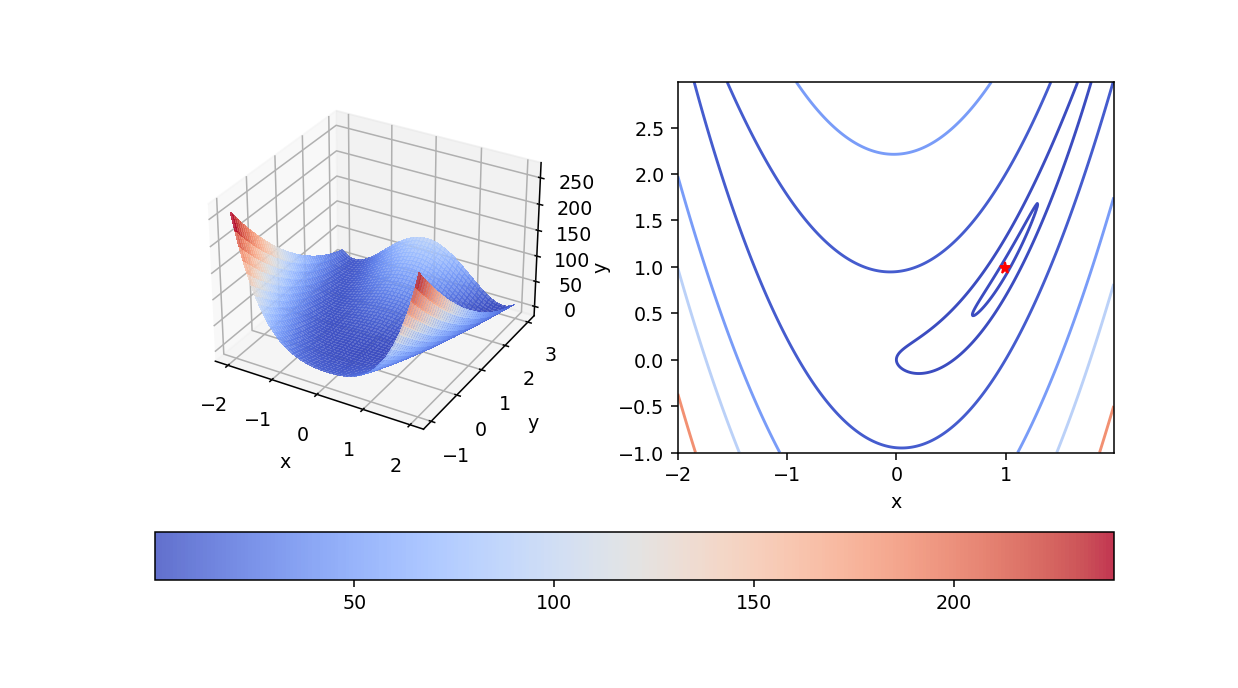

In [3]:
# Displaying the loss function

# Make data.
X = np.arange(-2, 2, 0.01)
Y = np.arange(-1, 3, 0.01)
X, Y = np.meshgrid(X, Y)
Z = loss(X, Y)

# The figure
fig = plt.figure(figsize=(9, 5))

# First subplot (3d plot)
ax1 = fig.add_subplot(1, 2, 1, projection="3d")
surf = ax1.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False, alpha=0.8)
ax1.scatter(ref_min_x, ref_min_y, loss(ref_min_x, ref_min_y), color='red')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

# Second subplot (contour plot)
levels = [1e-5, 1e-1, 1, 10, 50, 100, 200]
ax2 = fig.add_subplot(1, 2, 2)
ax2.contour(X, Y, Z, levels=levels, cmap=cm.coolwarm, vmin=np.amin(Z), vmax=np.amax(Z))
ax2.plot(ref_min_x, ref_min_y, "r*")
ax2.set_xlabel('x')
ax2.set_ylabel('y')

cb = plt.colorbar(surf, ax=[ax1, ax2], orientation="horizontal")

In [4]:
# The start point for the minimization
start_point = np.array([0.1, 2.5])

# nstep for each algorithms (easier to compare)
nstep = 300

In [5]:
# Function to play the animation of the results
def plot_method(*args):
    fig = plt.figure()
    plt.contour(X, Y, Z, levels=levels, cmap=cm.coolwarm, vmin=np.amin(Z), vmax=np.amax(Z), alpha=0.5)
    plt.plot(start_point[0], start_point[1], "rX")
    plt.plot(ref_min_x, ref_min_y, "g*")
    plt.xlabel('x')
    plt.ylabel('y')
    title = plt.title('it = 0')
    
    plots = []
    for res_method in args:
        plots.append(plt.plot(res_method[0, 0], res_method[0, 1], '-D', markevery=[-1])[0])
    
    def update(it):
        for iplot, res_method in enumerate(args):
            plots[iplot].set_data(res_method[:it+1, 0], res_method[:it+1, 1])
            plots[iplot].set_markevery([it])
        title.set_text(f"it = {it}")

        return plots, title
    
    return FuncAnimation(fig, update, frames=nstep, interval=10)

# Fixed learning rate methods

## Random search

This is a very naive approach.

The algorithm:
- chooses a random direction,
- computes the coordinates of a test point from the current point in that random direction scaled by the learning rate,
- checks the value of the loss function at this test point.

If this value is less than the value of the loss function at the current point, the current point is updated with the test point.  
If not, nothing happens.

In [6]:
# Random search
step = 0.1

p_rand = np.empty((nstep, 2))
p_rand[0, :] = start_point.copy()
m = loss(*start_point)
for n in range(1, nstep):
    test_point = p_rand[n-1, :] + step * np.random.uniform(-1, 1, 2)
    z = loss(*test_point)
    if z < m:
        m = z
        p_rand[n, :] = test_point
    else:
        p_rand[n, :] = p_rand[n-1, :]

<IPython.core.display.Javascript object>


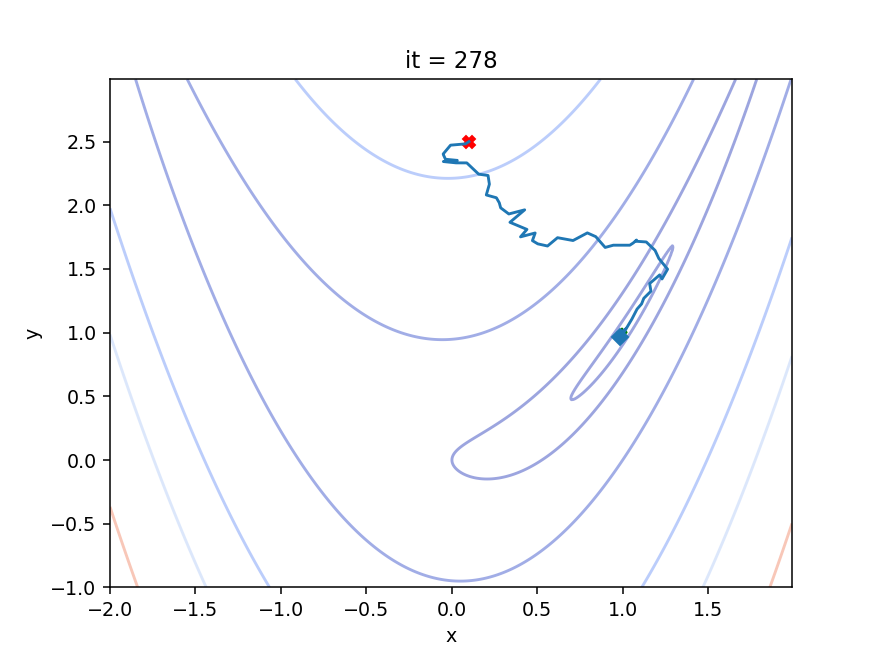

In [8]:
anim = plot_method(p_rand)

## Gradient descent

The classical gradient descent.  
Step size (learning rate) is fixed, the direction is the opposite of the gradient (minimization).

**Note** that, at the end, the gradient amplitude is low and the algorithm performs very small steps.

In [10]:
# Gradient Descent
step = 0.0005

p_gd = np.empty((nstep, 2))
p_gd[0, :] = start_point.copy()

for n in range(1, nstep):
    p_gd[n, :] = p_gd[n-1, :] - step * grad_loss(*p_gd[n-1, :])

<IPython.core.display.Javascript object>


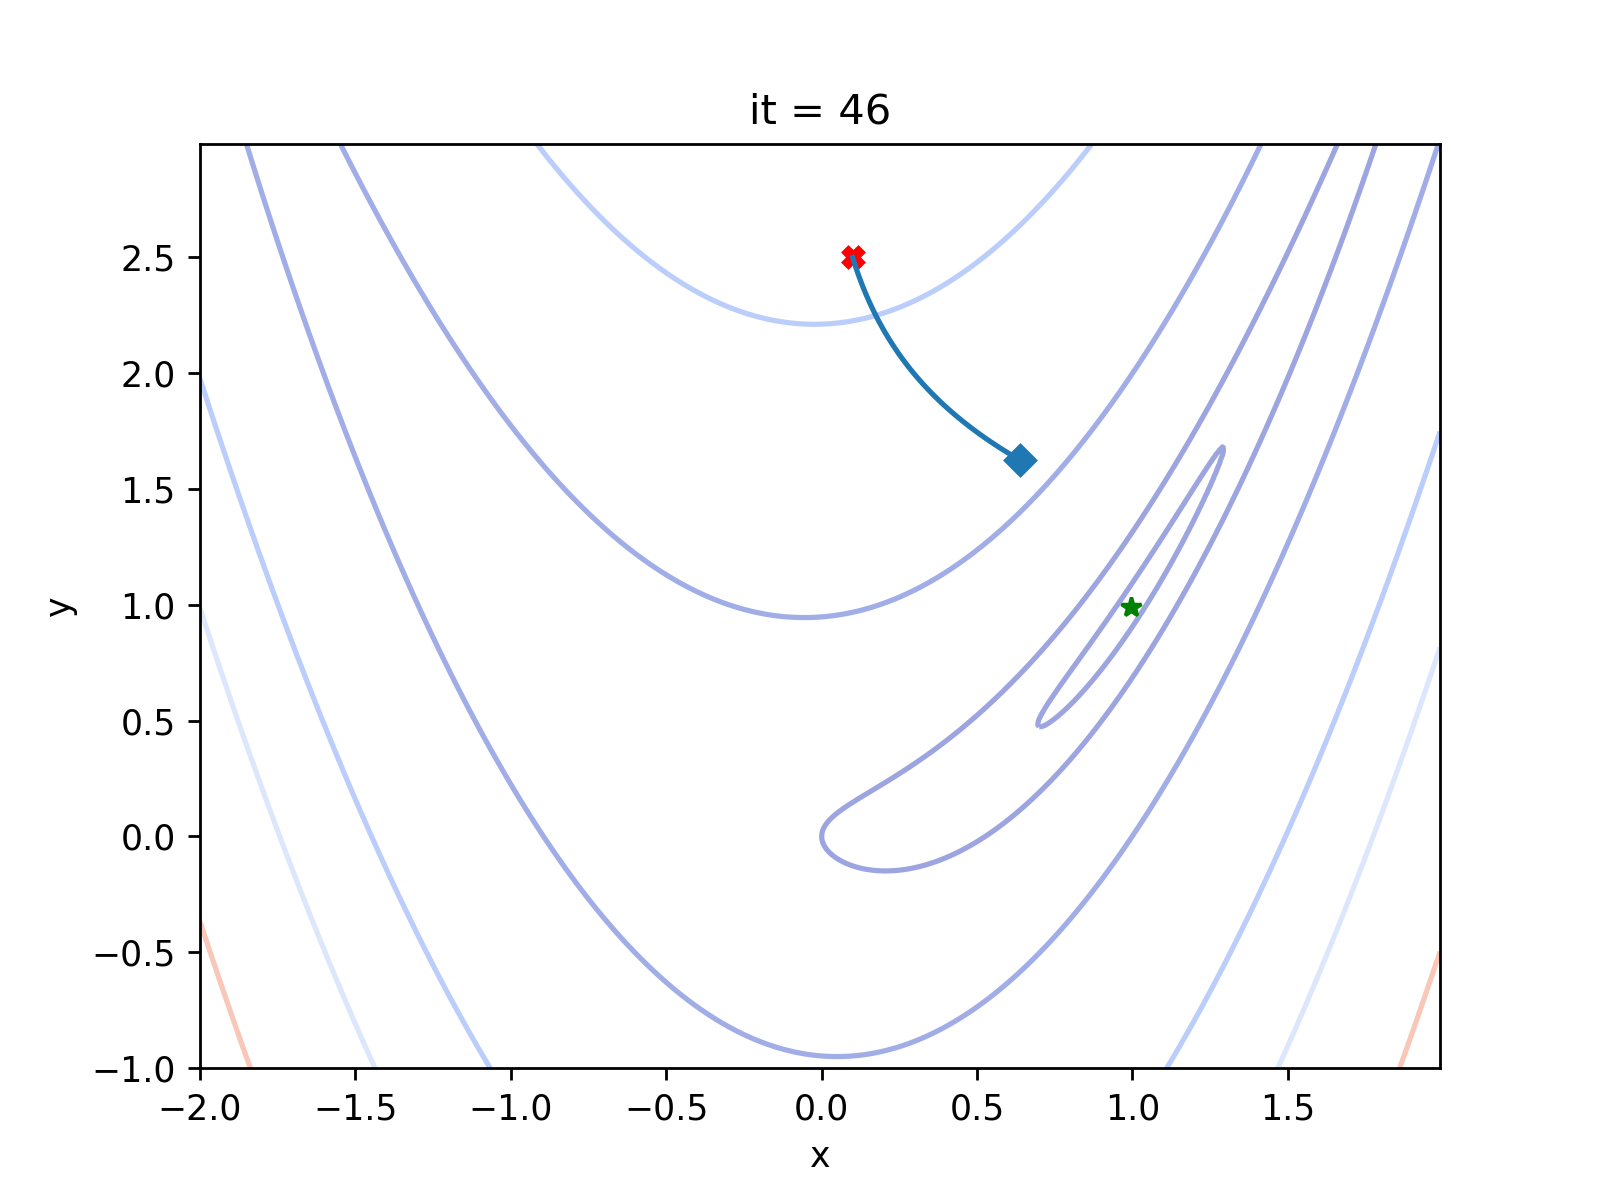

In [9]:
anim = plot_method(p_gd)

## Stochastic gradient descent

The loss function is a sum of functions that are very similar.  
Instead of computing the gradient of all functions in the sum (costly), only one function is used.  
This function is chosen randomly at each iteration of the algorithm.

Thus, this method is the same as the gradient descent, except that an approximation of the gradient is computed instead of the full gradient.  

It suffers from the same problems as the gradient descent. The learning rate is fixed and the gradient amplitude is low which results in very small steps at the end of the algorithm.

In [11]:
# Stochastic Gradient Descent
step = 0.0005

p_sgd = np.empty((nstep, 2))
p_sgd[0, :] = start_point.copy()

for n in range(1, nstep):
    batch = np.random.randint(0, N, 1)
    p_sgd[n, :] = p_sgd[n-1, :] - step * grad_loss_batch(batch, *p_sgd[n-1, :])

<IPython.core.display.Javascript object>


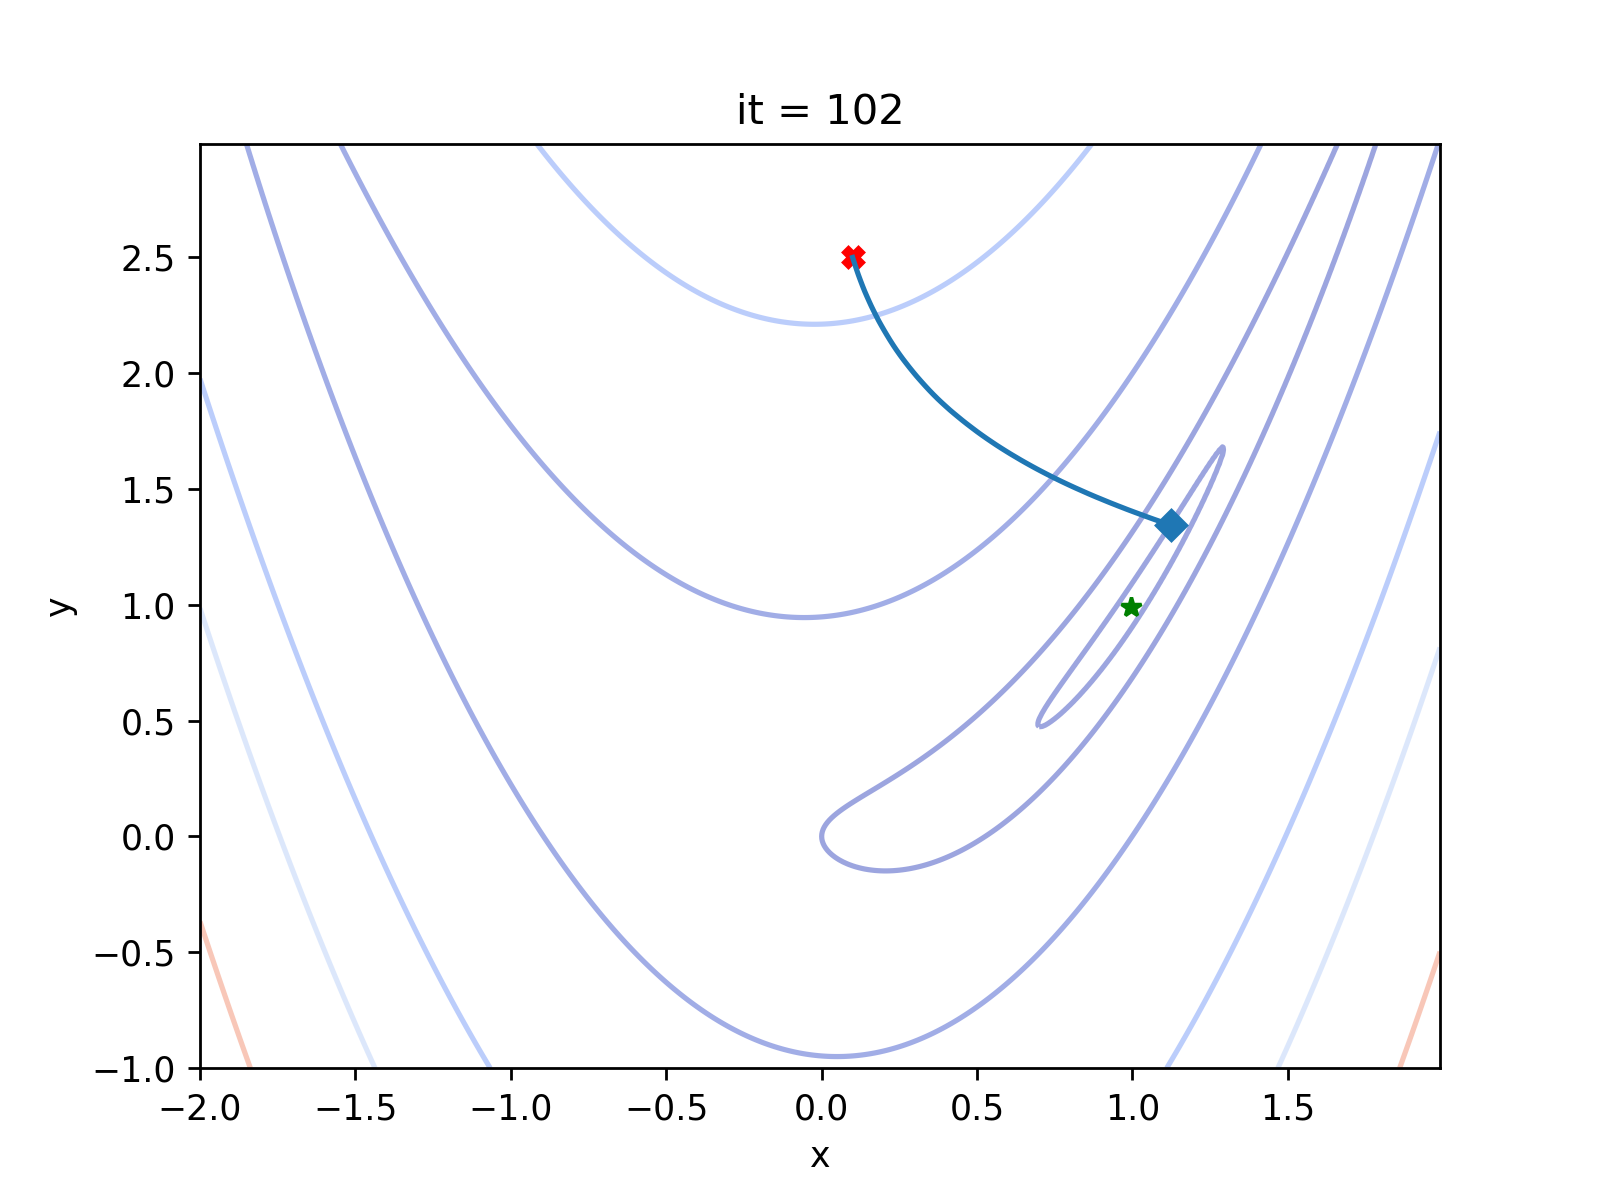

In [11]:
anim = plot_method(p_sgd)

## Nesterov's Accelerated Gradient (NAG)

Published in 1983 by Yurii Nesterov.
See also [Ilya Sutskever’s thesis](http://www.cs.utoronto.ca/~ilya/pubs/ilya_sutskever_phd_thesis.pdf), section 7.2.

This is based on the **momentum method**.

### Momentum method
We denote by $h$ the loss function. The algorithm iterates over the following operations:
$$v_{n+1} = \mu v_n - \alpha \nabla h(x_n) $$
$$x_{n+1} = x_n + v_{n+1}$$
where $v_0$ is initialized at $0$. The hyperparameter $\mu \in [0, 1]$ is the momentum constant (or $1-\mu$ is a friction coefficient), and $\alpha$ is the learning rate.

Here, the gradient is used to update a velocity instead of the position directly.

The constant $\mu$ controls the "decay" of the velocity:
a value close to $1$ means that the information of the previous gradients are kept for a longer time in the velocity.
In contrast, a zero value means that the previous gradients are forgotten at each step, like in the classical gradient descent method.

### NAG
In the momentum method, the new velocity is computed using the gradient of the loss function at the previous position.  
Instead of doing so, we use the information that the new point $x_{n+1}$ will be at the position $x_n + \mu v_n + ...$.

Thus, we can compute the gradient of the loss function at an ahead position: 
$$x_n^* = x_n + \mu v_n$$

The new algorithm writes:
$$x_n^* = x_n + \mu v_n$$
$$v_{n+1} = \mu v_n - \alpha \nabla h(x_n^*) $$
$$x_{n+1} = x_n + v_{n+1}$$

This can be re-written in terms of "ahead position" $x_n^*$:
$$v_{n+1} = \mu v_n - \alpha \nabla h(x_n^*) $$
$$x_{n+1}^* = x_n^* - \mu v_n + (1 + \mu) v_{n+1}$$

Which is what is implemented below:

In [12]:
# Nesterov momentum method
# Can be SGD's
step = 0.001
mu = 0.95
v = 0

p_momentum = np.empty((nstep, 2))
p_momentum[0, :] = start_point.copy()

for n in range(1, nstep):
    v_old = v
    v = mu * v - step * grad_loss(*p_momentum[n-1, :])
    p_momentum[n, :] = p_momentum[n-1, :] - mu * v_old + (1 + mu) * v

<IPython.core.display.Javascript object>


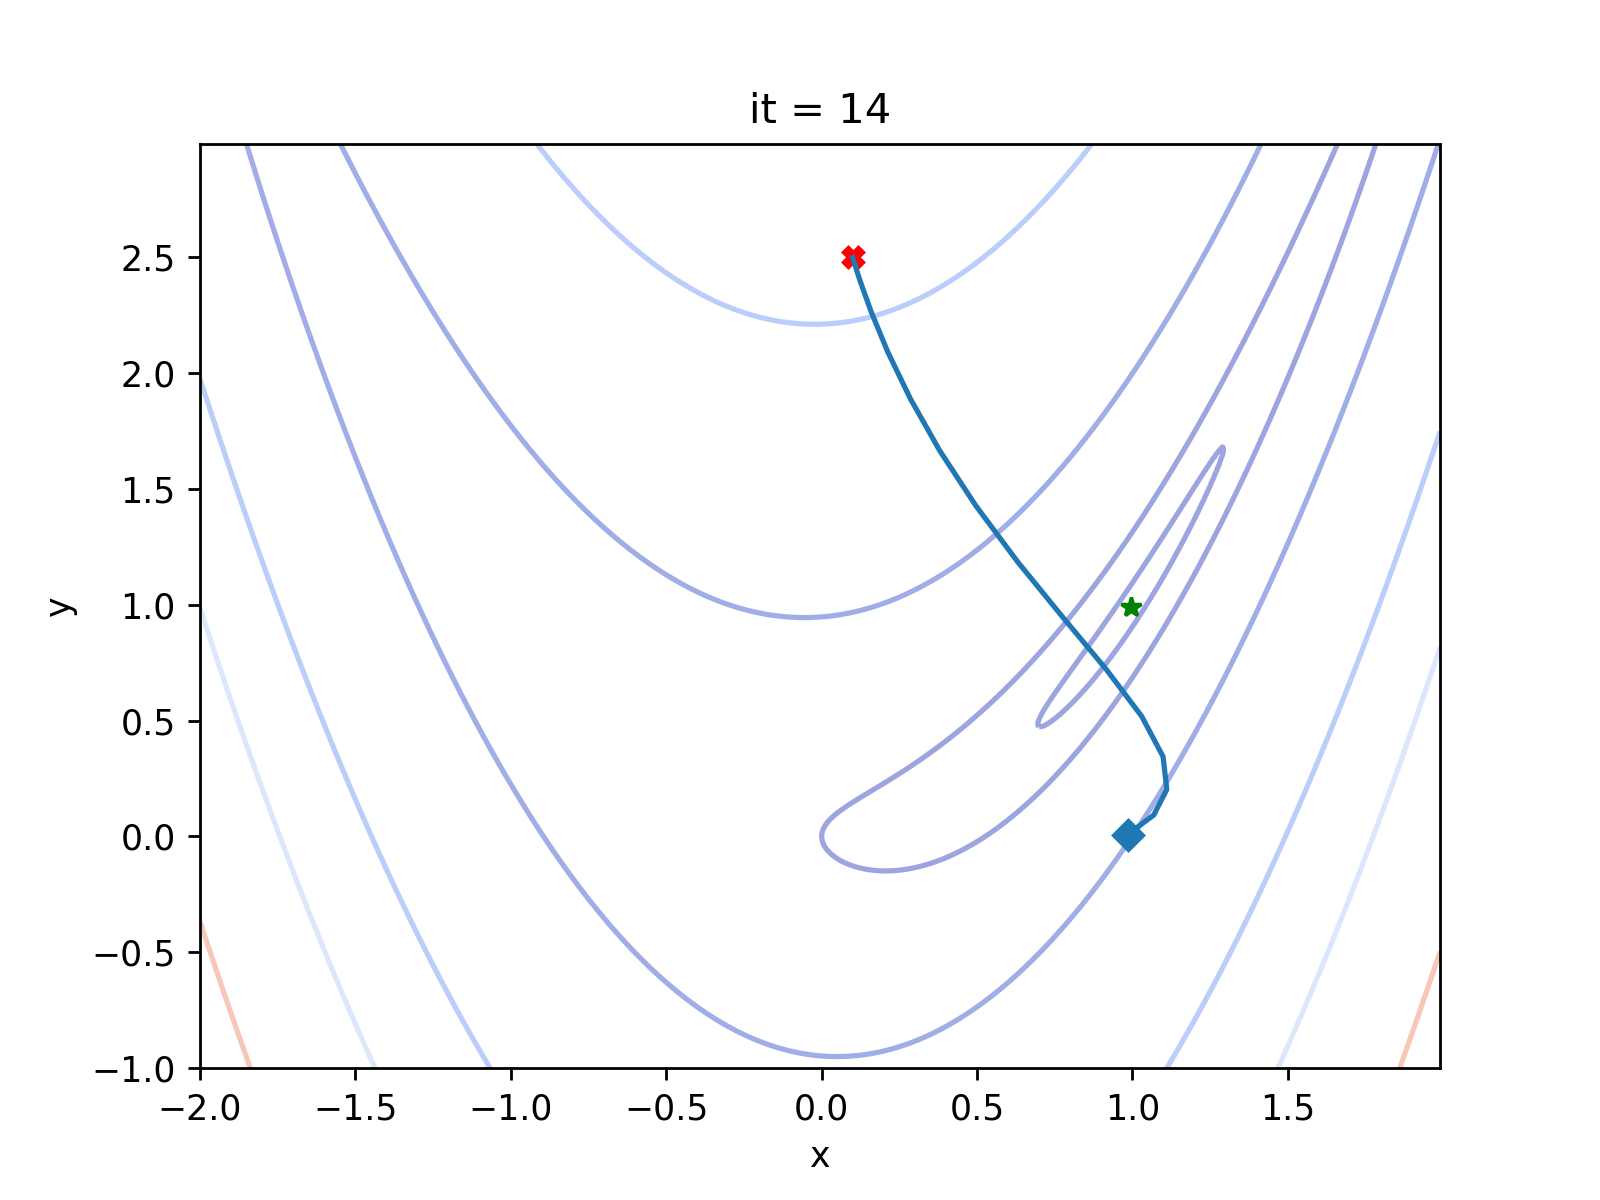

In [13]:
anim = plot_method(p_momentum)

# Per-parameter adaptive learning rate methods

These methods adapt the learning rate for each parameter depending on the value of the gradient.

## Adagrad

[Duchi, John, Hazan, Elad, and Singer, Yoram. Adaptive subgradient methods for online learning and stochasticoptimization. *The Journal of Machine Learning Research*, 12:2121–2159, 2011](http://jmlr.org/papers/v12/duchi11a.html)

The sum of the square of the gradient is kept in the variable `cache` in order to modify the learning rate. Note that it has the size of the gradient. Each parameter is modified with a different value (hence the "per parameter" keyword).

The parameter $\epsilon$ is an hyperparameter used to prevent division by $0$.

The problem with this algorithm is that the learning rate can only decrease.

In [13]:
# Adagrad
step = 0.5

p_adagrad = np.empty((nstep, 2))
p_adagrad[0, :] = start_point.copy()

# hyperparameter
eps = 1e-5

cache = np.zeros((1, 2))
for n in range(1, nstep):
    grad = grad_loss(*p_adagrad[n-1, :])
    cache += grad**2
    p_adagrad[n, :] = p_adagrad[n-1, :] - (step / (np.sqrt(cache) + eps)) * grad

<IPython.core.display.Javascript object>


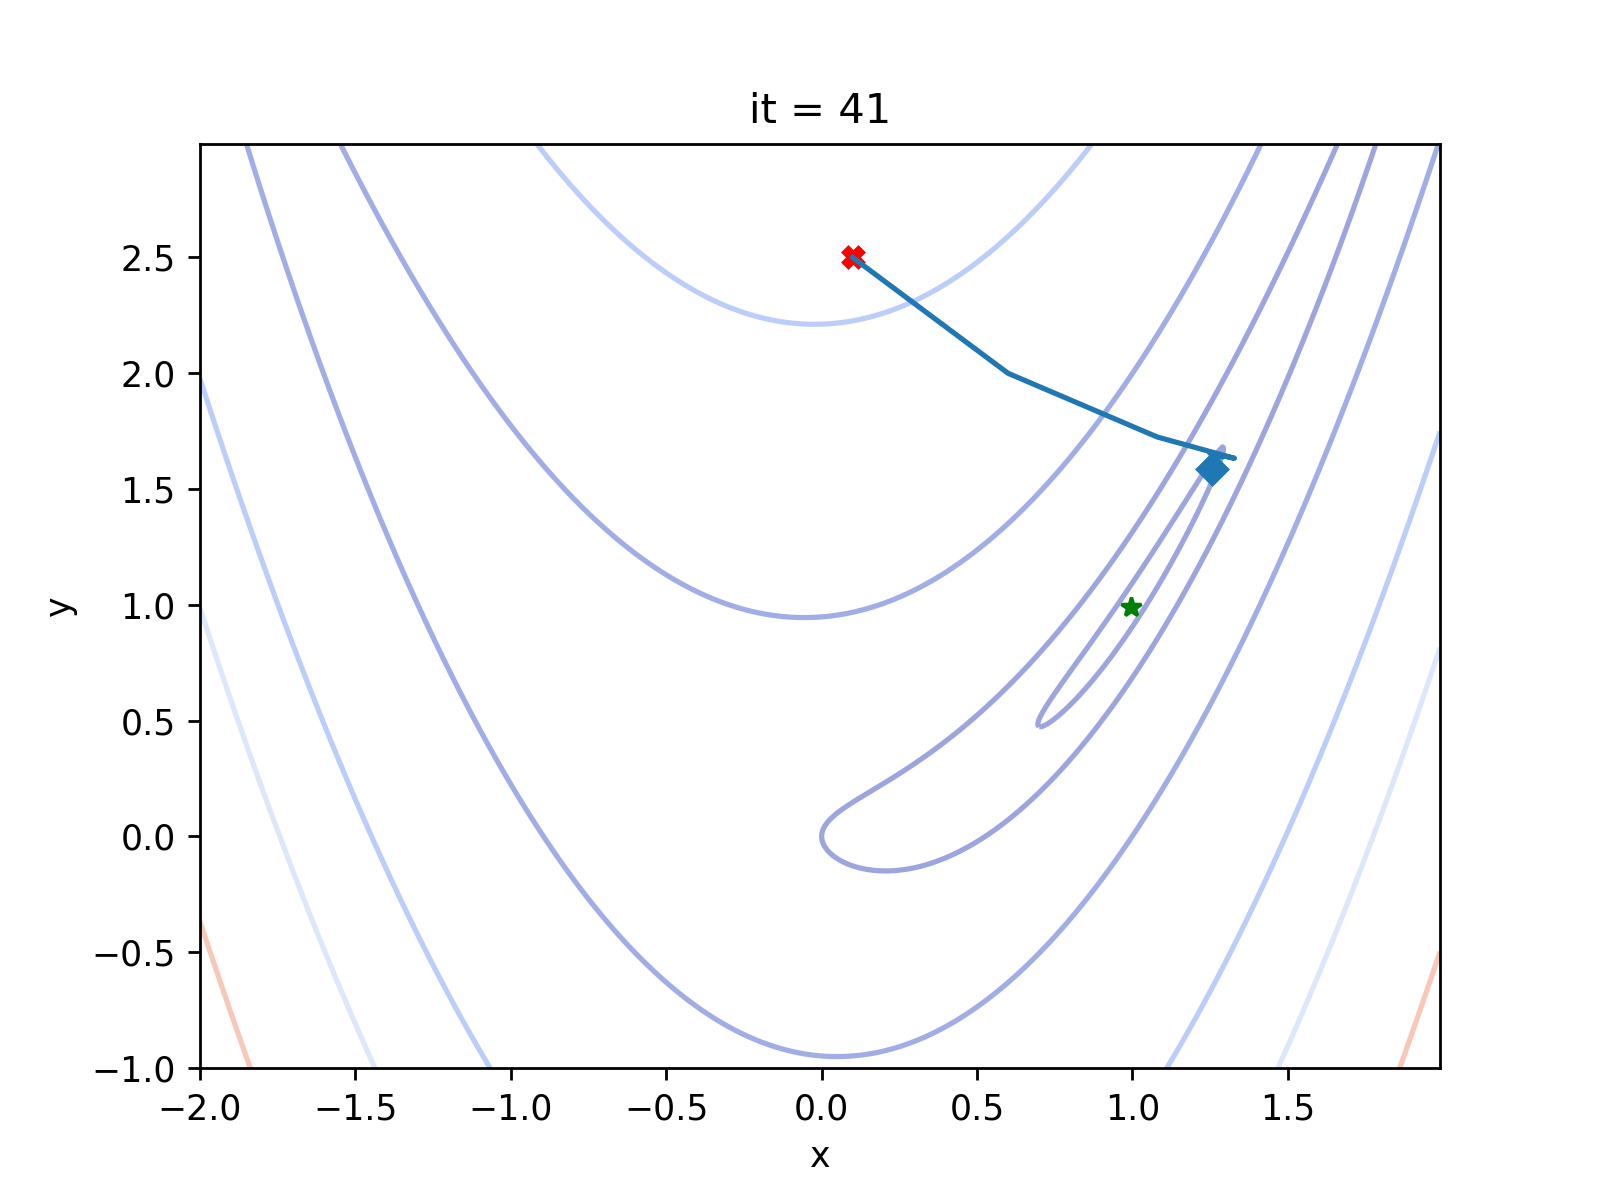

In [15]:
anim = plot_method(p_adagrad)

## RMSprop

Not published yet. https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf

This algorithm is very similar to Adagrad.  
It uses a moving average of squared gradients instead in order to reduce the aggressive, monotonically decreasing learning rate of Adagrad.  
It introduces a new hyperparameter `decay_rate` that controls this moving averaging.

In [14]:
# RMSprop
step = 0.1

p_rmsprop = np.empty((nstep, 2))
p_rmsprop[0, :] = start_point.copy()

# hyperparameter
eps = 1e-5
decay_rate = 0.99

cache = np.zeros((1, 2))
for n in range(1, nstep):
    grad = grad_loss(*p_rmsprop[n-1, :])
    cache = decay_rate * cache + (1 - decay_rate) * grad**2
    p_rmsprop[n, :] = p_rmsprop[n-1, :] - (step / (np.sqrt(cache) + eps)) * grad

<IPython.core.display.Javascript object>


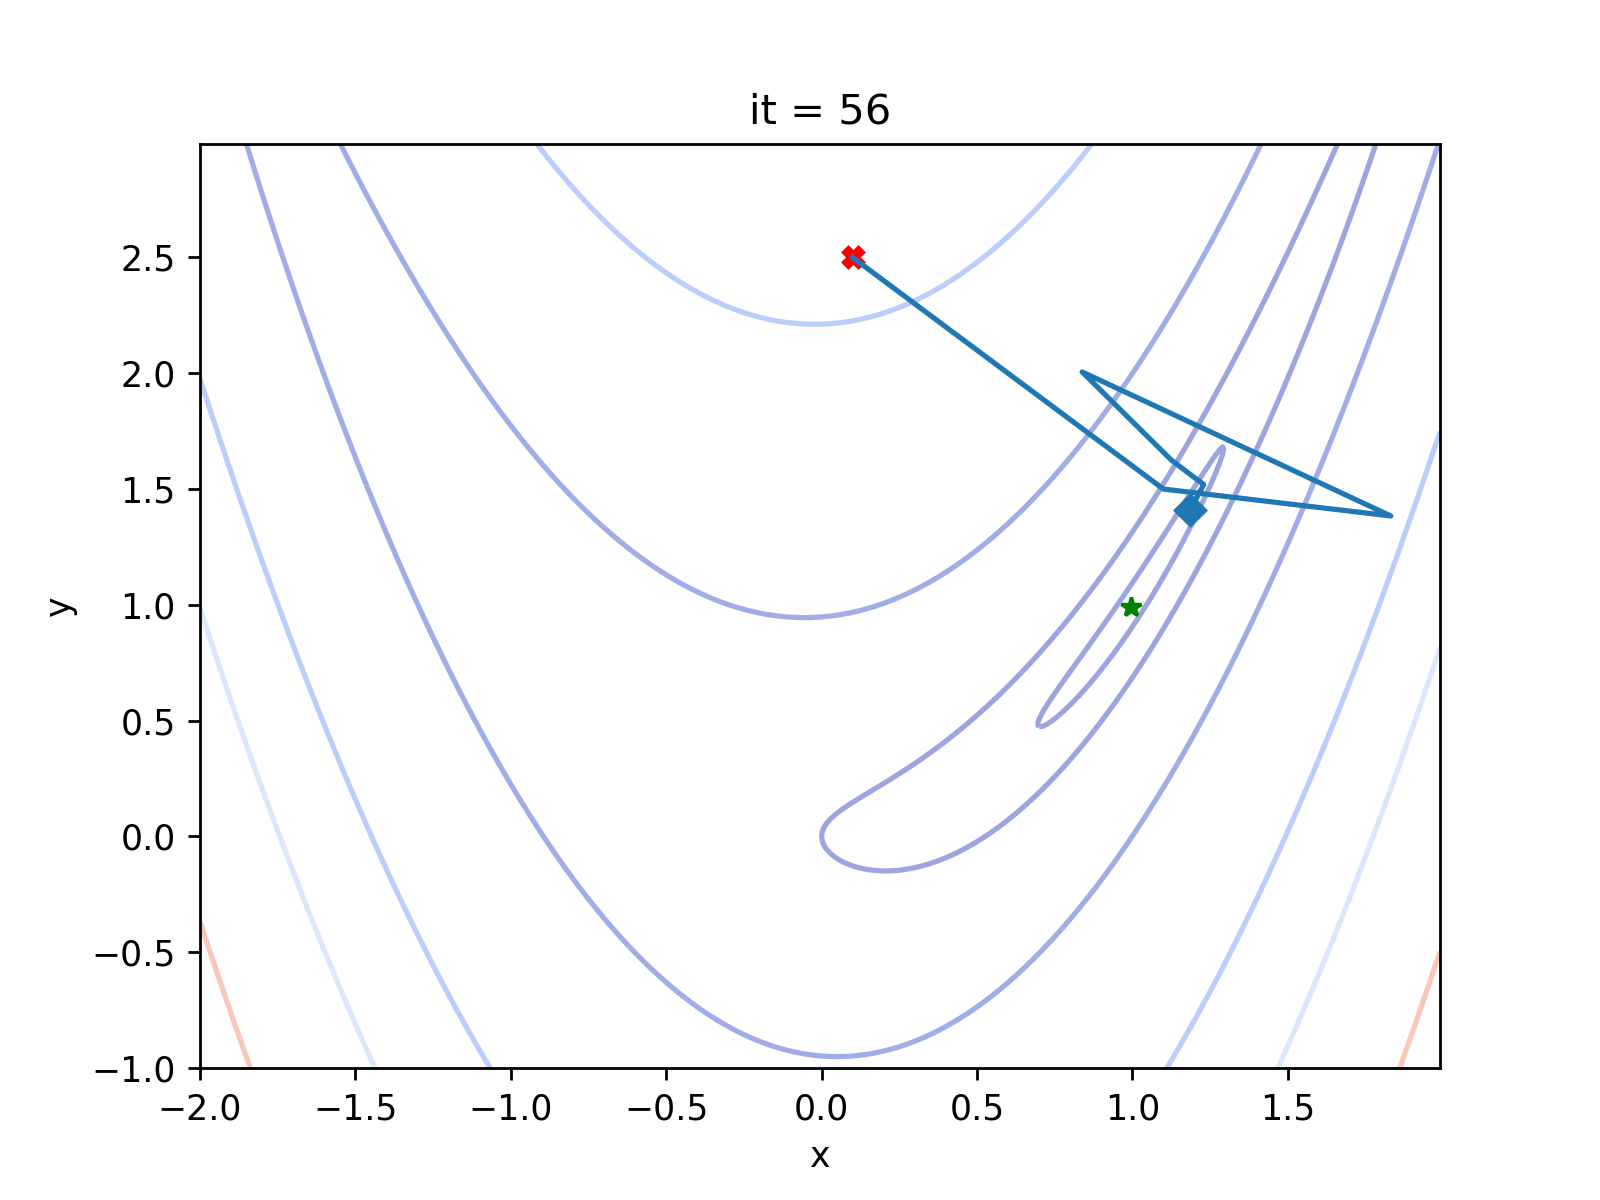

In [17]:
anim = plot_method(p_rmsprop)

## Adam

[Diederik P. Kingma, Jimmy Ba. Adam: A Method For Stochastic Optimization. *Published as a conference paper at the 3rd International Conference for Learning Representations, San Diego, 2015*](https://arxiv.org/abs/1412.6980v9)

It can be seen as RMSprop + Momentum to smooth the gradient.  
The simplified algorithm looks as follow:
$$m_{n+1} = \beta_1 m_n + (1 - \beta_1) \nabla h(x_n)$$

$$v_{n+1} = \beta_2 v_n + (1 - \beta_2) \nabla h(x_n)^2$$

$$x_{n+1} = x_n - \frac{\alpha}{\sqrt{v_{n+1}} + \epsilon} m_{n+1}$$

where $\beta_1$ and $\beta_2$ are two new hyperparameters, and $\nabla h(x_n)^2$ denotes the point-wise squaring of $\nabla h(x_n)$.

The full Adam update also includes a bias correction mechanism, which compensates for the fact that in the first few iterations the vectors $m$ and $v$ are both initialized and therefore biased at zero, before they fully “warm up”:
$$m_{n+1} = \beta_1 m_n + (1 - \beta_1) \nabla h(x_n), \qquad m_t = \frac{m_{n+1}}{1 - \beta_1^{n+1}}$$

$$v_{n+1} = \beta_2 v_n + (1 - \beta_2) \nabla h(x_n)^2, \qquad v_t = \frac{v_{n+1}}{1 - \beta_2^{n+1}}$$

$$x_{n+1} = x_n - \frac{\alpha}{\sqrt{v_t} + \epsilon} m_t$$

Note that in this new version the new position depends on the iteration number.

In [15]:
# Adam
step = 0.1

p_adam = np.empty((nstep, 2))
p_adam[0, :] = start_point.copy()

cache = np.zeros((1, 2))
eps = 1e-8
beta1 = 0.9
beta2 = 0.999
m = 0
v = 0
for n in range(1, nstep):
    grad = grad_loss(*p_adam[n-1, :])
    
    m = beta1 * m + (1 - beta1) * grad
    mt = m / (1 - beta1**n)
    v = beta2 * v + (1 - beta2) * grad**2
    vt = v / (1 - beta2**n)
    p_adam[n, :] = p_adam[n-1, :] - (step / (np.sqrt(vt) + eps)) * mt

<IPython.core.display.Javascript object>


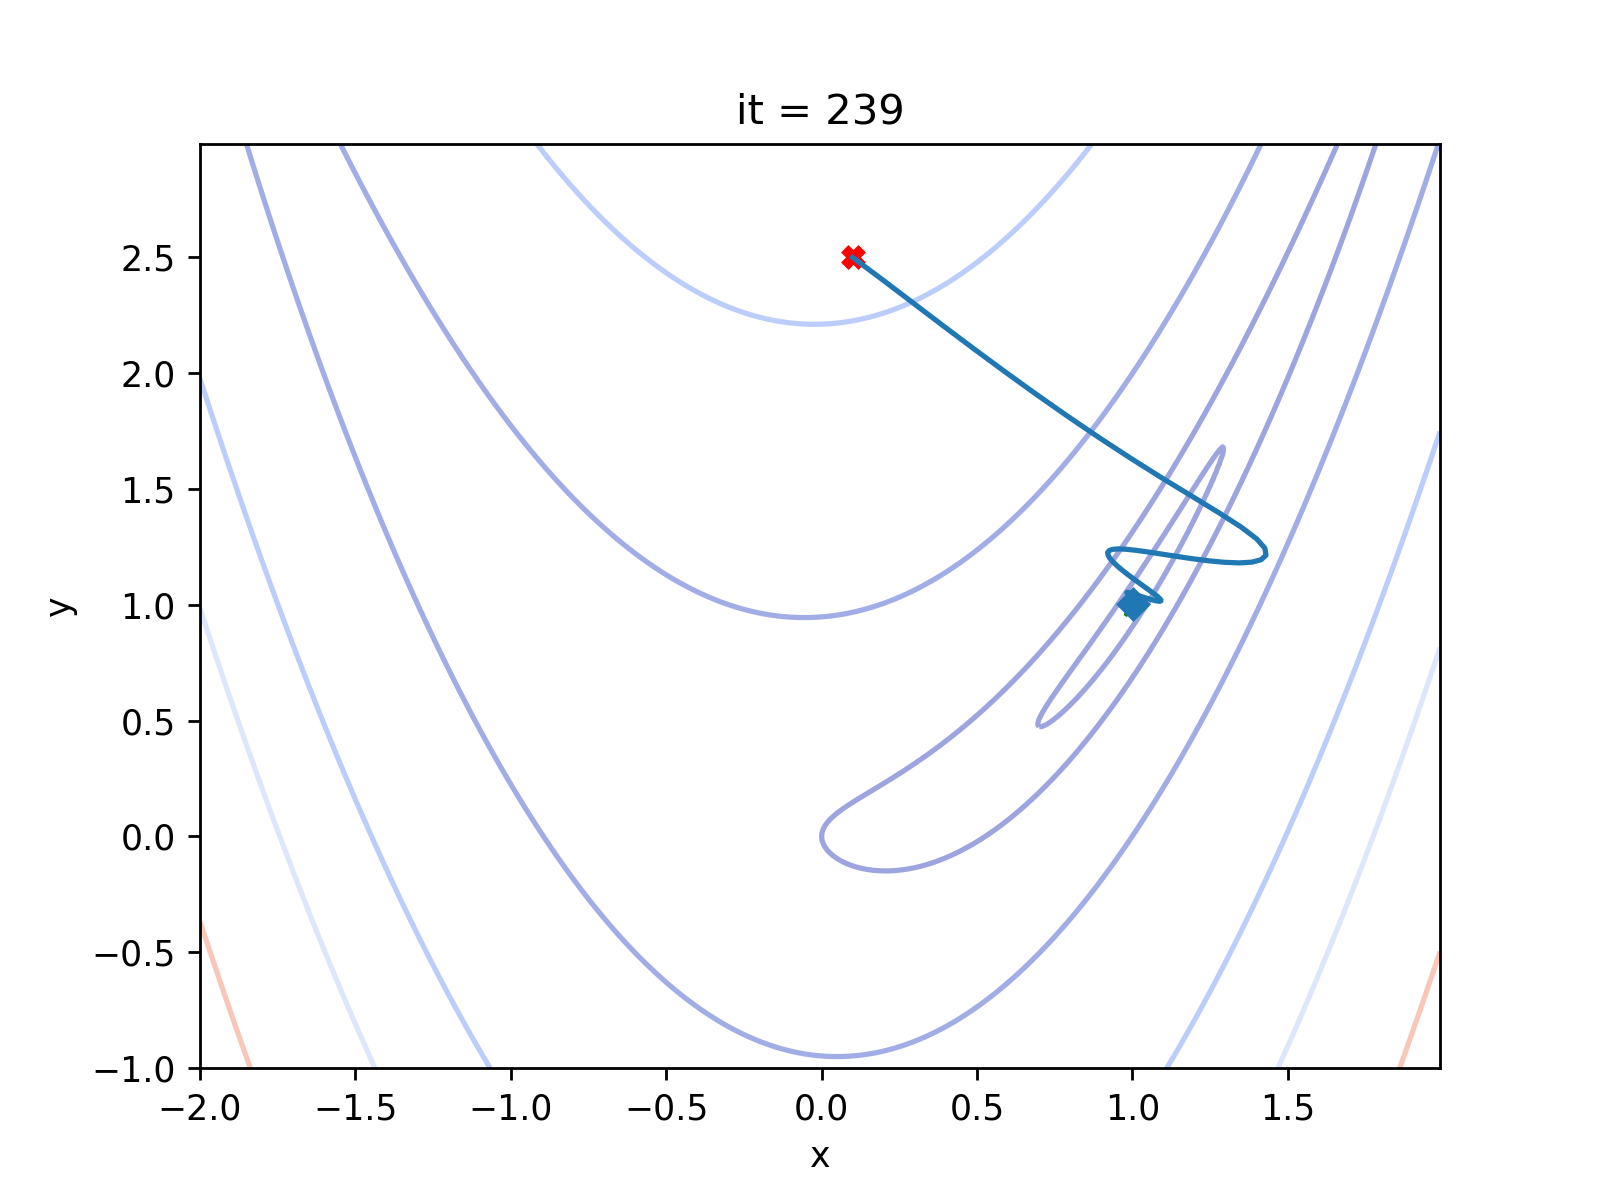

In [19]:
anim = plot_method(p_adam)

## Using scipy.optimize

`scipy.optimize` has a function called `minimize` that minimizes scalar function of one or more variables. Different methods can be used, like BFGS methods.  
It can be worth to give it a try.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize

In [16]:
# BFGS (scipy)
import scipy.optimize as spo

n = 0
p_scipy = np.empty((nstep, 2))
p_scipy[0, :] = start_point
p_scipy[1:, 0] = ref_min_x
p_scipy[1:, 1] = ref_min_y

def f_scipy(x):
    return loss(*x)

def jac_f_scipy(x):
    return grad_loss(*x)[0, :]

def callback(xk):
    global n
    n += 1
    p_scipy[n, :] = xk


res = spo.minimize(f_scipy, start_point, method='BFGS', jac=jac_f_scipy, tol=-1e-15, 
                   options={"maxiter" : nstep, "disp" : False}, callback=callback)

print(f"Number of iteration: {res.nit}")
print(f"Number of loss function evaluation: {res.nfev}")
print(f"Number of gradient loss function evaluation: {res.njev}")

Number of iteration: 21
Number of loss function evaluation: 56
Number of gradient loss function evaluation: 44


Note the number of evaluation of the loss function and its gradient.  
This method does not scale as well as the other methods. It's fast for this toy problem but may not work well for large scale minimization problems.

<IPython.core.display.Javascript object>


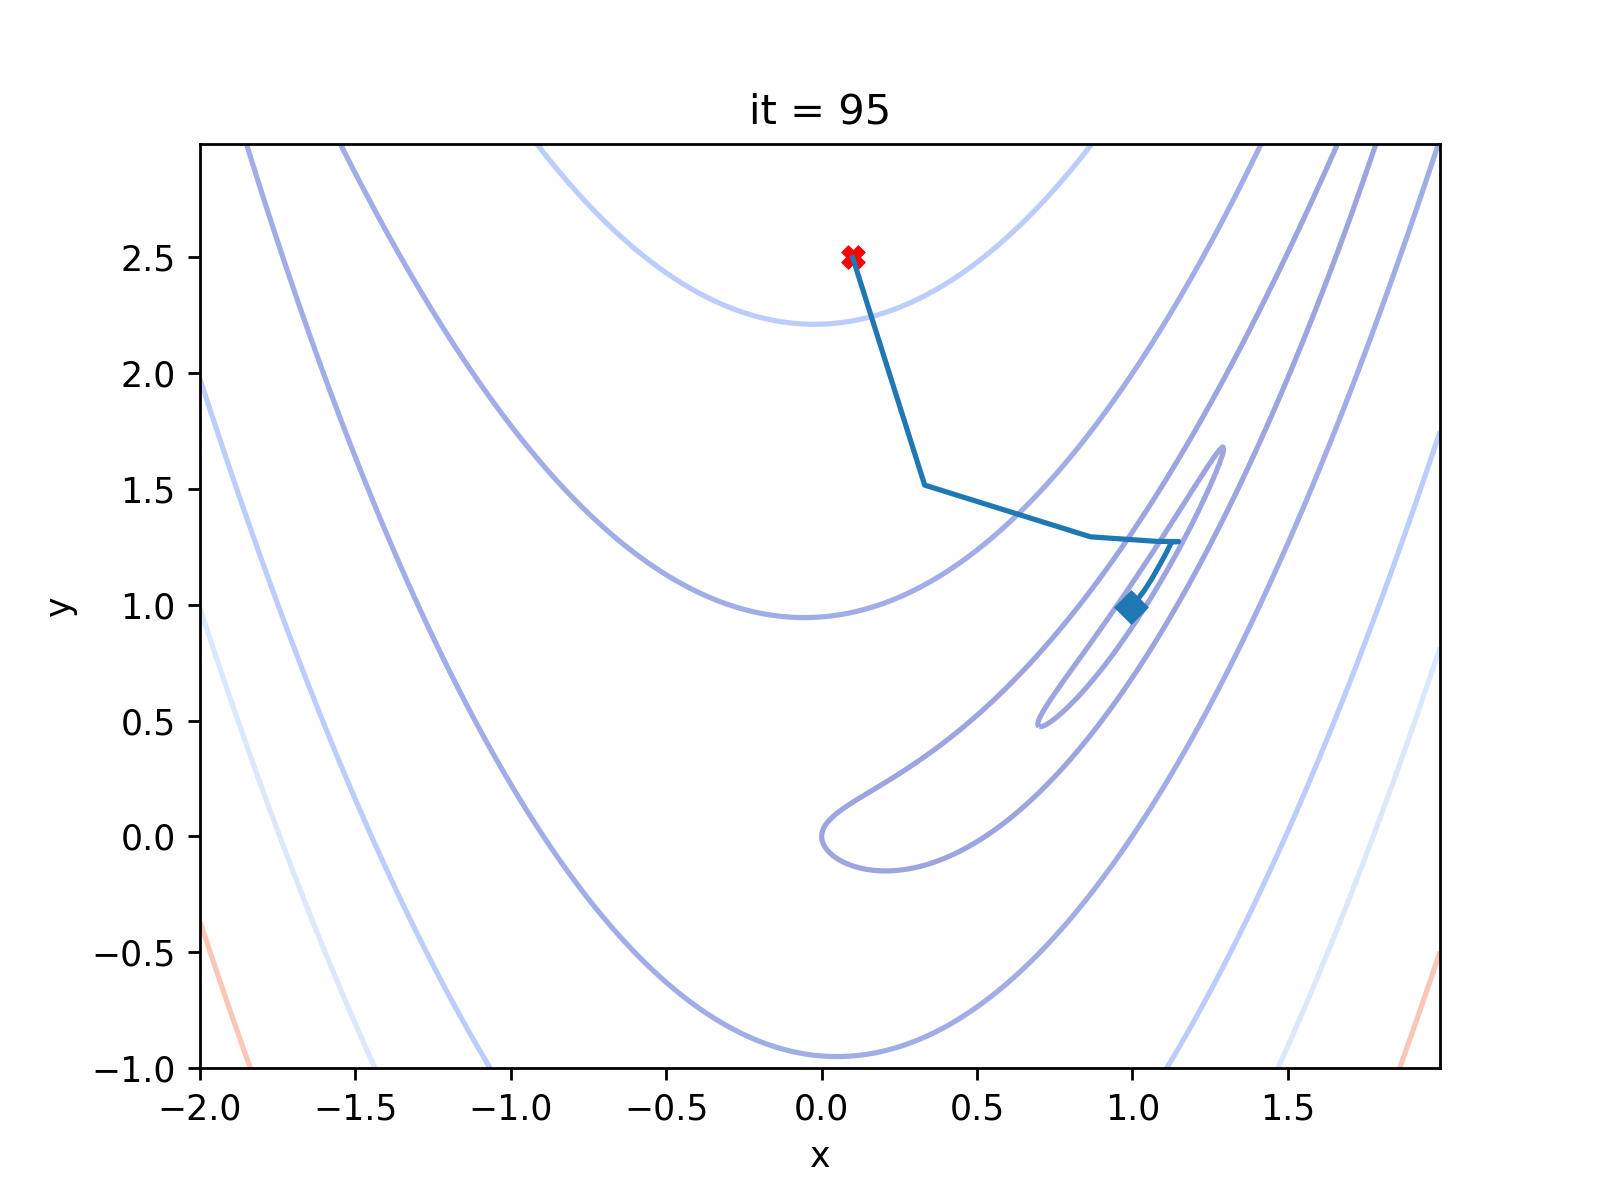

In [21]:
anim = plot_method(p_scipy)

## All results

<IPython.core.display.Javascript object>


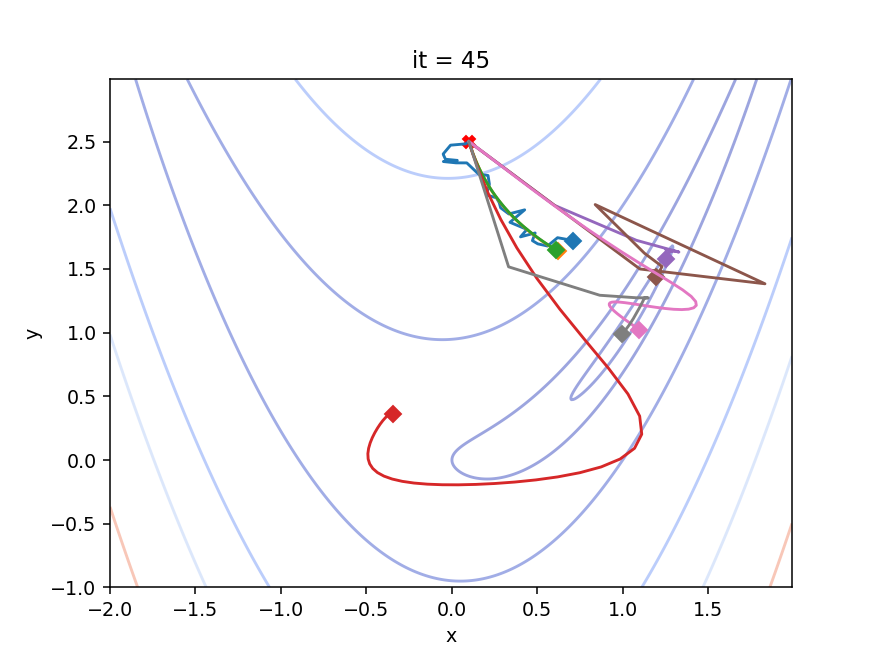

In [17]:
anim = plot_method(p_rand, p_gd, p_sgd, p_momentum, p_adagrad, p_rmsprop, p_adam, p_scipy)